# 决策树

TODO:每轮迭代需要展示的内容：\
1、当前数据集（经过上层选取的特征过滤后的剩余数据），以及总信息熵\
2、计算每个剩余特征的信息熵及信息增益\
3、当前树图\
4、取信息增益最大的作为分类节点\
5、分类后的树图\
[参考https://blog.csdn.net/weixin_43216017/article/details/87474045](https://blog.csdn.net/weixin_43216017/article/details/87474045)

优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据。\
缺点：可能会产生过度匹配问题。\
适用数据类型：数值型和标称型

### 决策树的一般流程

收集数据：可以适用任何方法。\
准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化。\
分析数据：可以使用任何方法，构造树完成之后，我们应该检查图形是否符合预期。\
训练算法：构造树的数据结构。\
测试算法：使用经验树计算错误率。\
使用算法：更好地理解数据内在含义。

In [1]:
import collections
import copy
import os
from collections import Counter
from typing import Dict, List

import ipywidgets as widgets
import pandas as pd

from IPython.display import display,Latex
from matplotlib import pyplot as plt

from dataset_producer import Dataset

import trees


In [2]:
DATA_DIR = ".\dataset"
all_data_path = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        all_data_path.append(os.path.join(root, file))

new_dataset=Dataset()
def show_data(path):
    global new_dataset
    new_dataset=Dataset(path=path,haveHead=True)
    display(new_dataset.data)
widgets.interact(show_data,path=all_data_path)

interactive(children=(Dropdown(description='path', options=('.\\dataset\\human.CSV', '.\\dataset\\lenses.txt',…

<function __main__.show_data(path)>

计算总信息熵

In [3]:
myDat=new_dataset.data.to_numpy()

d=Counter(new_dataset.data.iloc[:,-1])
print(new_dataset.head[-1],d)

def latex_total_ent(d:{}):
    """
    输入计算总信息熵的字典，返回latex string
    :param d:
    :return:
    """
    ans= '$info(D)='
    denominator=sum(d.values())#分母
    #每个label产生一个多项式
    for i in d:
        numerator=d[i]#分子
        term='-\\frac{%d}{%d}log_2(\\frac{%d}{%d})' %(numerator,denominator,numerator,denominator)
        ans+=term
    ans+= '=%f$' % trees.calcShannonEnt(d)
    return ans

Latex(latex_total_ent(d))

贷款审批结果 Counter({'是': 9, '否': 6})


<IPython.core.display.Latex object>

计算条件信息熵和信息增益

In [4]:
def latex_condition_ent(ent_info, condition_num:int):
    """
    输入信息熵的字典，返回所有latex string，包含条件信息熵和信息增益
    :param ent_info:List[Entropy,Dict[int,Dict[str,Entropy]]]，列表第一个是总信息熵，第二个条件信息熵
    :return:
    """
    d=ent_info[1][condition_num]
    condition=new_dataset.head[condition_num]
    total_ent=ent_info[0].ent_value

    latex_list=[]
    denominator_list=[]
    ent_list=[]
    for condition_value in d:
        ans= '$info(D|%s==%s)='%(condition,condition_value)
        counter=d[condition_value].ent_dict
        denominator=sum(counter.values())#分母
        denominator_list.append(denominator)
        #每个label产生一个多项式
        for i in counter:
            numerator=counter[i]#分子
            term='-\\frac{%d}{%d}log_2(\\frac{%d}{%d})' %(numerator,denominator,numerator,denominator)
            ans+=term
        ans+= '=%f$' % d[condition_value].ent_value
        ent_list.append(d[condition_value].ent_value)
        latex_list.append(ans)

    #计算总体
    ans= '$info(D|%s)='%condition
    terms=[]
    condition_ent=0
    for i in range(len(denominator_list)):
        term='\\frac{%d}{%d}\\times{%f}'%(denominator_list[i],sum(denominator_list),ent_list[i])
        terms.append(term)
        condition_ent+= denominator_list[i] / sum(denominator_list) * ent_list[i]
    ans+='+'.join(terms)
    ans+='=%f$' % condition_ent
    latex_list.append(ans)

    #计算增益
    ans='$Gain(%s)=%f-%f=%f$'%(condition,total_ent,condition_ent,total_ent-condition_ent)
    latex_list.append(ans)
    return latex_list

ent_info,bestFeat = trees.chooseBestFeatureToSplit(myDat)

def show_condition(property:int):
    latex_list=latex_condition_ent(ent_info,property)
    for latex in latex_list:
        display(Latex(latex))
# show_condition(0)

property_string=new_dataset.head[:-1]
op=[(new_dataset.head[i],i) for i in range(new_dataset.dimension-1)]
widget_property=widgets.Dropdown(
    options=op,
    description='选择属性:',
)
widgets.interact(show_condition,property=widget_property)
display(new_dataset.data)

interactive(children=(Dropdown(description='选择属性:', options=(('年龄', 0), ('是否工作', 1), ('是否有房子', 2), ('信贷情况', 3)…

,年龄,是否工作,是否有房子,信贷情况,贷款审批结果
0,老年,否,是,很好,是
1,老年,否,是,很好,是
2,老年,是,否,好,是
3,老年,是,否,好,是
4,老年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,很好,是
9,中年,否,是,很好,是


每轮选择信息增益最大的属性作为分类节点，生成决策树

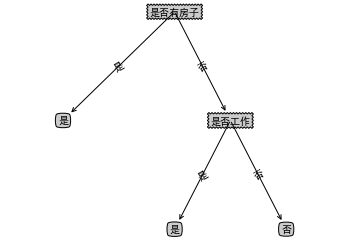

In [5]:
myTree  = trees.createTree(new_dataset.data)
plt.rcParams['font.sans-serif'] = ['SimHei']
trees.createPlot(myTree)

In [6]:
#debug用全局变量
show_tree=[]
show_set=[]
show_ent_info=[]
def createTree(dataSet:pd.DataFrame):
    """
    在原有的trees.createTree进行改动，通过全局变量记录下每次递归决策树的变化
    :param dataSet:
    :return:
    """
    global show_tree,show_set,show_ent_info
    # 每次执行前展示一下当前数据集
    show_set+=[dataSet]

    numpy_set=dataSet.to_numpy()
    classList = numpy_set[:,-1]
    if len(collections.Counter(classList))==1:
        show_ent_info+=[(collections.Counter(classList),None)]
        return classList[0]#stop splitting when all of the classes are equal，剩余标签是同一类
    # if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet，#只剩下一个数据
    #     return majorityCnt(classList)
    ent_info,bestFeat = trees.chooseBestFeatureToSplit(numpy_set)

    # show_info用于展示每轮如何选择最好的特征
    show_ent_info+=[ent_info]

    bestFeatLabel = dataSet.columns[bestFeat]
    myTree = {bestFeatLabel:{}}

    show_tree+=[copy.deepcopy(myTree)]
    
    #对于最好特征那一列的每个可取value
    for value in set(numpy_set[:,bestFeat]):
        #过滤
        filt_set=numpy_set[numpy_set[:,bestFeat]==value,:]
        #用过滤的np.ndarray重新构建df，特征和原来相同，再把最好特征那一列删去
        new_set=pd.DataFrame(data=filt_set,columns=dataSet.columns)
        new_set=new_set.drop(bestFeatLabel,axis=1)
        myTree[bestFeatLabel][value] = createTree(new_set)

        show_tree+=[copy.deepcopy(myTree)]

    return myTree

print(createTree(new_dataset.data))
print(show_tree)

{'是否有房子': {'是': '是', '否': {'是否工作': {'是': '是', '否': '否'}}}}
[{'是否有房子': {}}, {'是否有房子': {'是': '是'}}, {'是否工作': {}}, {'是否工作': {'是': '是'}}, {'是否工作': {'是': '是', '否': '否'}}, {'是否有房子': {'是': '是', '否': {'是否工作': {'是': '是', '否': '否'}}}}]


FIXME:treePlotter中传入字典画图对传入字典有要求，传入一个节点的字典，画不出一个节点的树 \
TODO：考虑使用graphviz画出决策树，而非matplotlib

In [18]:
#初始化全局变量用于可视化
show_tree=[]
show_set=[]
show_ent_info=[]

createTree(new_dataset.data)

out_set,out_tree,out_text=widgets.Output(),widgets.Output(),widgets.Output()

new_op=[(show_set[0].columns[i],i) for i in range(show_set[0].shape[1]-1)]
new_widget_property=widgets.Dropdown(options=new_op,description='选择属性:')
n_widget = widgets.IntSlider(min=0, max=len(show_set)-1, description='',
                             continuous_update=False,value=0)
def update_dropdown(*args):
    n=n_widget.value
    new_op=[(show_set[n].columns[i],i) for i in range(show_set[n].shape[1]-1)]
    new_widget_property.options=new_op
n_widget.observe(update_dropdown,'value')

def show(n:int,condition_num:int):
    if show_ent_info[n][1]!=None:
        total_ent=latex_total_ent(show_ent_info[n][0].ent_dict)
        condition_ent=latex_condition_ent(ent_info=show_ent_info[n],condition_num=condition_num)
    else:
        total_ent=latex_total_ent(show_ent_info[n][0])
        condition_ent=["剩余的类标签都是同一类，总信息熵为0"]
    with out_set:
        out_set.clear_output()
        display(show_set[n])
    with out_text:
        out_text.clear_output()
        display(Latex(total_ent))
        for i in condition_ent:
            display(Latex(i))
        # display(show_ent_info[n])
    with out_tree:
        out_tree.clear_output()
        plt.rcParams['font.sans-serif'] = ['SimHei']
        # TODO:把-1换成n逐步展示决策树生成过程
        trees.createPlot(show_tree[-1])

print(len(show_set),len(show_ent_info),len(show_tree))


a=widgets.interactive(show,n=n_widget,condition_num=new_widget_property)
display(a)
# display(widgets.HBox([out_set,out_text]))
# display(out_tree)
display(widgets.HBox([out_set,widgets.VBox([out_text,out_tree])]))
# display(widgets.HBox([n_widget,new_widget_property]))

5 6 5


interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=4), Dropdown(descriptio…